<a href="https://colab.research.google.com/github/luongnhung-1410/gold_price_prediction/blob/main/gold_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('/content/data_final.xlsx')

In [ ]:
df.describe(include=[np.number])

,GLD,VNI,OIL,EXR
count,1126.000000,1126.000000,1126.000000,1126.000000
mean,67.570844,1229.364076,79.874494,23.707998
std,8.232809,137.600900,13.356334,0.831402
min,54.650000,911.900000,47.280000,22.625000
25%,61.427500,1120.740000,71.842500,23.020000
50%,67.200000,1230.885000,78.270000,23.470000
75%,70.400000,1297.230000,85.515000,24.370000
max,91.300000,1528.570000,126.470000,25.469000


**Trực quan hóa mối quan hệ giữa biến giá vàng và biến khác**

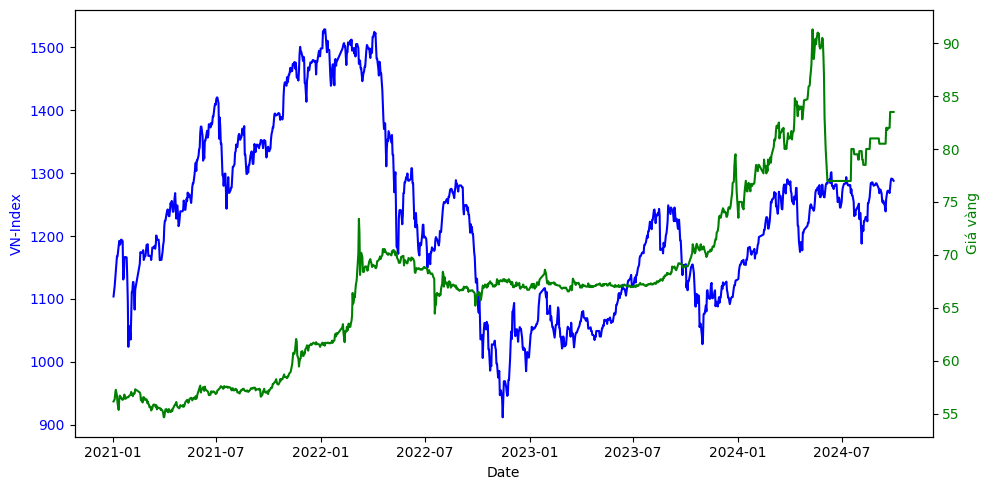

In [ ]:
# Chuyển đổi cột 'date' sang định dạng datetime
df['date'] = pd.to_datetime(df['date'])

# Vẽ biểu đồ với hai trục y
fig, ax1 = plt.subplots(figsize=(10, 5))

# Trục y đầu tiên cho 'vn_index'
ax1.plot(df['date'], df['VNI'], label='VN-Index', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('VN-Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Tạo trục y thứ hai cho biến khác (ví dụ: 'other_variable')
ax2 = ax1.twinx()  # Chia sẻ trục x với ax1
ax2.plot(df['date'], df['GLD'], label='Giá vàng', color='green')
ax2.set_ylabel('Giá vàng', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Thêm tiêu đề và hiển thị biểu đồ

fig.tight_layout()  # Tự động điều chỉnh bố cục
plt.show()


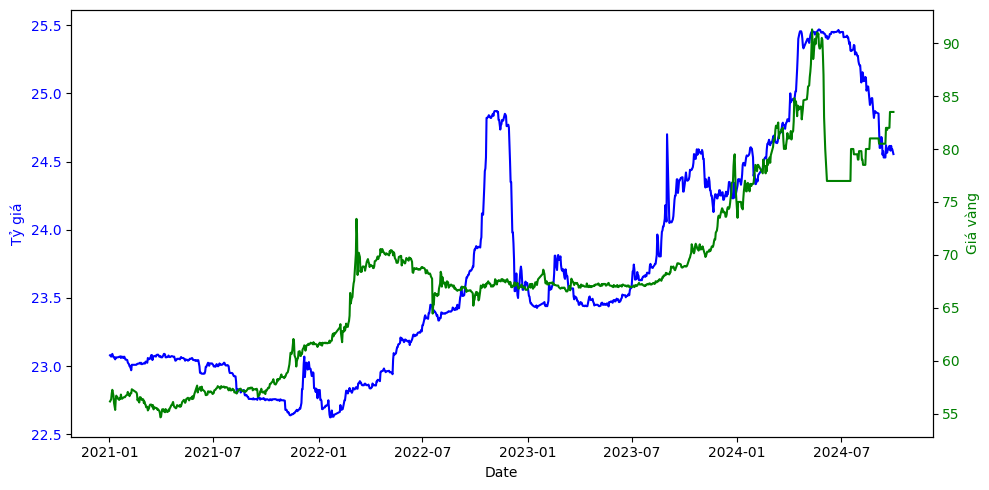

In [ ]:
# Vẽ biểu đồ với hai trục y
fig, ax1 = plt.subplots(figsize=(10, 5))

# Trục y đầu tiên cho 'vn_index'
ax1.plot(df['date'], df['EXR'], label='Tỷ giá USD/VND', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tỷ giá', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Tạo trục y thứ hai cho biến khác (ví dụ: 'other_variable')
ax2 = ax1.twinx()  # Chia sẻ trục x với ax1
ax2.plot(df['date'], df['GLD'], label='Giá vàng', color='green')
ax2.set_ylabel('Giá vàng', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Thêm tiêu đề và hiển thị biểu đồ
fig.tight_layout()  # Tự động điều chỉnh bố cục
plt.show()


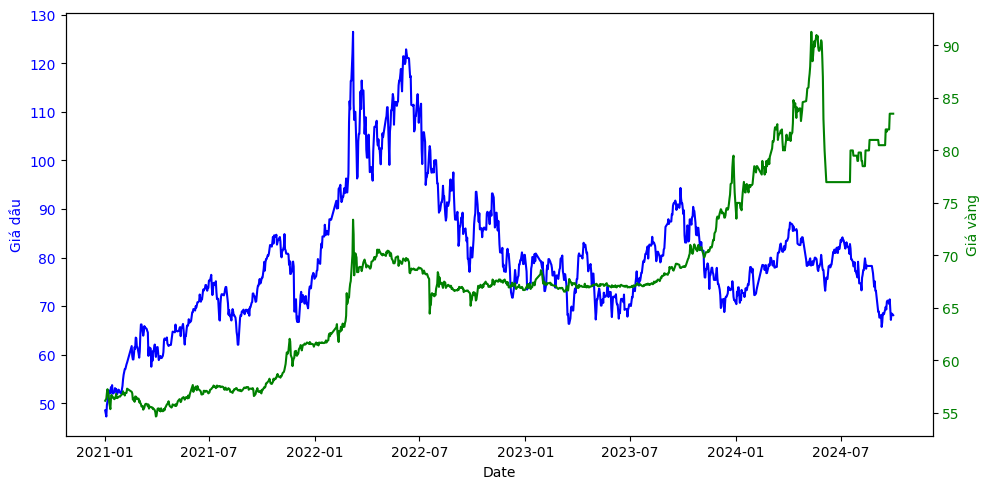

In [ ]:

# Vẽ biểu đồ với hai trục y
fig, ax1 = plt.subplots(figsize=(10, 5))

# Trục y đầu tiên cho 'vn_index'
ax1.plot(df['date'], df['OIL'], label='Giá dầu', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Giá dầu', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Tạo trục y thứ hai cho biến khác (ví dụ: 'other_variable')
ax2 = ax1.twinx()  # Chia sẻ trục x với ax1
ax2.plot(df['date'], df['GLD'], label='Giá vàng', color='green')
ax2.set_ylabel('Giá vàng', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Thêm tiêu đề và hiển thị biểu đồ
fig.tight_layout()  # Tự động điều chỉnh bố cục
plt.show()


**Loại bỏ cột date trước khi train model**

In [3]:
df=df.drop(columns=['date'])

**Hệ số tương quan**

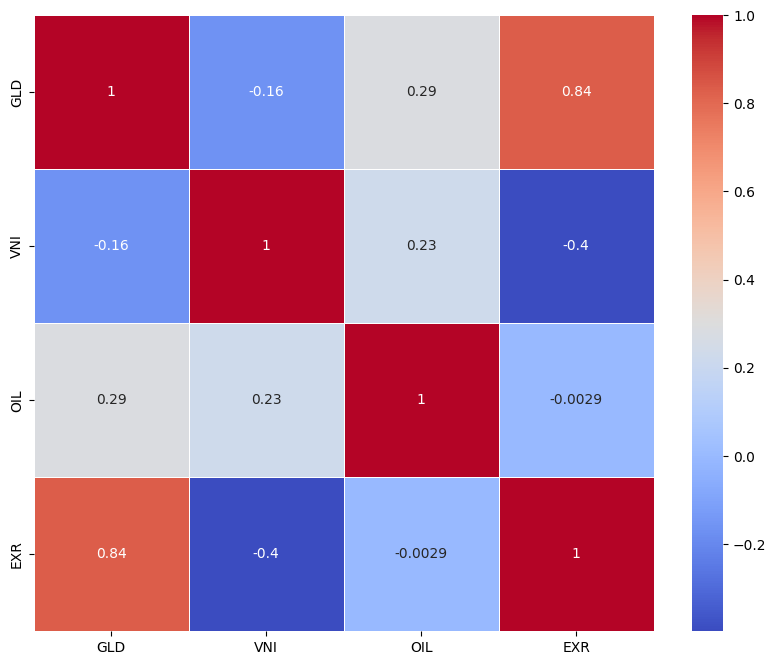

In [ ]:
import seaborn as sns

# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Hiển thị
plt.show()


***Mô hình LSTM***

In [4]:
# Giả sử df_scaled đã chuẩn hóa và là một pandas DataFrame
train_df = df[:int(len(df)*0.8)]  # 80% dữ liệu cho train
test_df = df[int(len(df)*0.8):]  # 20% dữ liệu cho test


*Chuẩn hóa dữ liệu tập train*

In [5]:
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df.iloc[:, :])  # Chọn tất cả các cột

# Tạo dataframe cho dữ liệu chuẩn hóa
train_lstm = pd.DataFrame(scaled_data, columns=train_df.columns)

In [6]:
# Chuẩn hóa tập test dựa trên scaler đã fit từ tập train
test_scaled = scaler.transform(test_df.iloc[:, :])

# Tạo dataframe cho dữ liệu test đã chuẩn hóa
test_lstm = pd.DataFrame(test_scaled, columns=test_df.columns)

In [7]:
train_lstm = train_lstm.to_numpy()
test_lstm = test_lstm.to_numpy()

*Tạo input/output cho tập train*

In [8]:
def create_dataset(dataset, n_obs, n_pred):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_obs - n_pred + 1):
        # Lấy chuỗi n_obs ngày liên tiếp cho dataX
        a = dataset[i:(i + n_obs), :]  # Chọn tất cả các cột cho mỗi chuỗi
        dataX.append(a)
        # Lấy n_pred ngày tiếp theo từ cột đầu tiên cho dataY
        dataY.append(dataset[i + n_obs:i + n_obs + n_pred, 0])  # Chỉ lấy cột đầu tiên
    return np.array(dataX), np.array(dataY)

X_train_lstm, y_train_lstm = create_dataset(train_lstm,10,1)
X_test_lstm, y_test_lstm = create_dataset(test_lstm,10,1)

***Buil model***

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import random
from sklearn.metrics import mean_squared_error

*Tối ưu siêu tham số bằng optuna*

In [10]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [11]:
import optuna

In [12]:
def objective(trial):

    lstm_units   = trial.suggest_int('lstm_units', 16, 128)                 # Số đơn vị LSTM
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)  # Tỷ lệ dropout
    epochs       = trial.suggest_int('epochs', 5, 50)                       # Số epoch
    batch_size   = trial.suggest_int('batch_size', 16, 128)                 # Kích thước batch

    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    # Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(10, train_lstm.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    # Biên dịch mô hình
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Huấn luyện mô hình
    model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size, verbose=0)

    # Dự báo trên tập huấn luyện để tính MSE cho tập train
    train_lstm_predict = model.predict(X_train_lstm)

    # Tính MSE trên dữ liệu đã chuẩn hóa (không cần rescale)
    mse = mean_squared_error(y_train_lstm, train_lstm_predict)

    # Return MSE để Optuna tối ưu
    return mse



In [13]:
# Tạo một study để tối ưu hóa
study = optuna.create_study(direction='minimize')  # 'minimize' vì chúng ta muốn giảm mất mát

# Tìm kiếm siêu tham số tối ưu
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần với các bộ siêu tham số khác nhau


[I 2024-12-24 07:44:53,406] A new study created in memory with name: no-name-c1318c5e-49fc-46cc-9bbf-8bb904b40f07
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:44:59,860] Trial 0 finished with value: 0.01311812583636938 and parameters: {'lstm_units': 50, 'dropout_rate': 0.5, 'epochs': 6, 'batch_size': 89}. Best is trial 0 with value: 0.01311812583636938.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 07:45:26,877] Trial 1 finished with value: 0.008082348448891495 and parameters: {'lstm_units': 121, 'dropout_rate': 0.4, 'epochs': 37, 'batch_size': 118}. Best is trial 1 with value: 0.008082348448891495.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:45:31,541] Trial 2 finished with value: 0.013961454668148687 and parameters: {'lstm_units': 29, 'dropout_rate': 0.30000000000000004, 'epochs': 9, 'batch_size': 99}. Best is trial 1 with value: 0.008082348448891495.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[I 2024-12-24 07:45:48,034] Trial 3 finished with value: 0.012100614499544183 and parameters: {'lstm_units': 88, 'dropout_rate': 0.5, 'epochs': 35, 'batch_size': 127}. Best is trial 1 with value: 0.008082348448891495.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:46:02,972] Trial 4 finished with value: 0.00981484088534349 and parameters: {'lstm_units': 49, 'dropout_rate': 0.5, 'epochs': 45, 'batch_size': 96}. Best is trial 1 with value: 0.008082348448891495.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


[I 2024-12-24 07:46:40,280] Trial 5 finished with value: 0.005502637404925215 and parameters: {'lstm_units': 116, 'dropout_rate': 0.1, 'epochs': 29, 'batch_size': 16}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:46:50,727] Trial 6 finished with value: 0.008604511670902612 and parameters: {'lstm_units': 30, 'dropout_rate': 0.1, 'epochs': 39, 'batch_size': 74}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:47:09,953] Trial 7 finished with value: 0.0077392311856020425 and parameters: {'lstm_units': 88, 'dropout_rate': 0.30000000000000004, 'epochs': 42, 'batch_size': 114}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 07:47:20,496] Trial 8 finished with value: 0.012656970658658062 and parameters: {'lstm_units': 17, 'dropout_rate': 0.4, 'epochs': 42, 'batch_size': 76}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[I 2024-12-24 07:47:34,820] Trial 9 finished with value: 0.009015659198625414 and parameters: {'lstm_units': 93, 'dropout_rate': 0.4, 'epochs': 21, 'batch_size': 105}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 07:48:09,132] Trial 10 finished with value: 0.00784478531950018 and parameters: {'lstm_units': 114, 'dropout_rate': 0.1, 'epochs': 24, 'batch_size': 31}. Best is trial 5 with value: 0.005502637404925215.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:48:49,866] Trial 11 finished with value: 0.005111266264759457 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2, 'epochs': 50, 'batch_size': 18}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[I 2024-12-24 07:49:48,474] Trial 12 finished with value: 0.006113454314378522 and parameters: {'lstm_units': 105, 'dropout_rate': 0.2, 'epochs': 50, 'batch_size': 17}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:49:58,436] Trial 13 finished with value: 0.009169148813543202 and parameters: {'lstm_units': 73, 'dropout_rate': 0.2, 'epochs': 17, 'batch_size': 46}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-24 07:50:26,031] Trial 14 finished with value: 0.009336137109001327 and parameters: {'lstm_units': 127, 'dropout_rate': 0.2, 'epochs': 31, 'batch_size': 51}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[I 2024-12-24 07:50:55,715] Trial 15 finished with value: 0.005734533405659384 and parameters: {'lstm_units': 103, 'dropout_rate': 0.1, 'epochs': 30, 'batch_size': 19}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-12-24 07:51:16,030] Trial 16 finished with value: 0.006453572067529939 and parameters: {'lstm_units': 72, 'dropout_rate': 0.2, 'epochs': 50, 'batch_size': 48}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-24 07:51:30,504] Trial 17 finished with value: 0.007921819537618696 and parameters: {'lstm_units': 106, 'dropout_rate': 0.1, 'epochs': 14, 'batch_size': 31}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:51:44,949] Trial 18 finished with value: 0.008468676402941602 and parameters: {'lstm_units': 74, 'dropout_rate': 0.2, 'epochs': 25, 'batch_size': 59}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 07:52:22,251] Trial 19 finished with value: 0.0072052687854494 and parameters: {'lstm_units': 115, 'dropout_rate': 0.1, 'epochs': 31, 'batch_size': 33}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:52:36,096] Trial 20 finished with value: 0.009135607573713173 and parameters: {'lstm_units': 97, 'dropout_rate': 0.30000000000000004, 'epochs': 18, 'batch_size': 65}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-24 07:53:12,653] Trial 21 finished with value: 0.005757890608572699 and parameters: {'lstm_units': 107, 'dropout_rate': 0.1, 'epochs': 30, 'batch_size': 16}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


[I 2024-12-24 07:53:58,217] Trial 22 finished with value: 0.0062131055367980305 and parameters: {'lstm_units': 127, 'dropout_rate': 0.1, 'epochs': 34, 'batch_size': 27}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-24 07:54:21,006] Trial 23 finished with value: 0.012902056611215271 and parameters: {'lstm_units': 102, 'dropout_rate': 0.2, 'epochs': 27, 'batch_size': 39}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[I 2024-12-24 07:54:56,269] Trial 24 finished with value: 0.00572415606726115 and parameters: {'lstm_units': 84, 'dropout_rate': 0.1, 'epochs': 46, 'batch_size': 20}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:55:29,238] Trial 25 finished with value: 0.0059686889897127395 and parameters: {'lstm_units': 85, 'dropout_rate': 0.2, 'epochs': 46, 'batch_size': 23}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


[I 2024-12-24 07:55:49,458] Trial 26 finished with value: 0.006971409524650903 and parameters: {'lstm_units': 62, 'dropout_rate': 0.1, 'epochs': 47, 'batch_size': 39}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


[I 2024-12-24 07:56:11,565] Trial 27 finished with value: 0.008205813058210571 and parameters: {'lstm_units': 81, 'dropout_rate': 0.2, 'epochs': 41, 'batch_size': 40}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-12-24 07:56:46,846] Trial 28 finished with value: 0.006243965728513779 and parameters: {'lstm_units': 115, 'dropout_rate': 0.1, 'epochs': 45, 'batch_size': 57}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


[I 2024-12-24 07:56:52,002] Trial 29 finished with value: 0.011651348753003556 and parameters: {'lstm_units': 62, 'dropout_rate': 0.2, 'epochs': 7, 'batch_size': 82}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 07:57:28,687] Trial 30 finished with value: 0.006150961108508845 and parameters: {'lstm_units': 97, 'dropout_rate': 0.30000000000000004, 'epochs': 50, 'batch_size': 26}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-24 07:58:07,030] Trial 31 finished with value: 0.005314595569477142 and parameters: {'lstm_units': 111, 'dropout_rate': 0.1, 'epochs': 36, 'batch_size': 20}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-12-24 07:58:53,753] Trial 32 finished with value: 0.005839454161892717 and parameters: {'lstm_units': 120, 'dropout_rate': 0.1, 'epochs': 37, 'batch_size': 23}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 07:59:36,148] Trial 33 finished with value: 0.006923970182373099 and parameters: {'lstm_units': 110, 'dropout_rate': 0.1, 'epochs': 35, 'batch_size': 36}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 08:00:19,159] Trial 34 finished with value: 0.005361039453728252 and parameters: {'lstm_units': 95, 'dropout_rate': 0.1, 'epochs': 39, 'batch_size': 16}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 08:00:47,514] Trial 35 finished with value: 0.008204366536201152 and parameters: {'lstm_units': 96, 'dropout_rate': 0.2, 'epochs': 38, 'batch_size': 26}. Best is trial 11 with value: 0.005111266264759457.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-24 08:01:32,063] Trial 36 finished with value: 0.0051053530672891985 and parameters: {'lstm_units': 117, 'dropout_rate': 0.1, 'epochs': 33, 'batch_size': 16}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-24 08:02:04,883] Trial 37 finished with value: 0.0061371674825698545 and parameters: {'lstm_units': 122, 'dropout_rate': 0.1, 'epochs': 33, 'batch_size': 44}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 08:02:33,125] Trial 38 finished with value: 0.007976120244613678 and parameters: {'lstm_units': 91, 'dropout_rate': 0.30000000000000004, 'epochs': 41, 'batch_size': 30}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 08:03:01,754] Trial 39 finished with value: 0.006441960172769029 and parameters: {'lstm_units': 101, 'dropout_rate': 0.2, 'epochs': 37, 'batch_size': 25}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-24 08:03:55,648] Trial 40 finished with value: 0.006902276277321875 and parameters: {'lstm_units': 111, 'dropout_rate': 0.5, 'epochs': 44, 'batch_size': 16}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


[I 2024-12-24 08:04:28,876] Trial 41 finished with value: 0.005925455159863829 and parameters: {'lstm_units': 120, 'dropout_rate': 0.1, 'epochs': 27, 'batch_size': 22}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-24 08:05:16,512] Trial 42 finished with value: 0.006977573189767282 and parameters: {'lstm_units': 119, 'dropout_rate': 0.4, 'epochs': 35, 'batch_size': 16}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-12-24 08:05:59,647] Trial 43 finished with value: 0.007246394625012606 and parameters: {'lstm_units': 112, 'dropout_rate': 0.1, 'epochs': 40, 'batch_size': 33}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-24 08:06:44,752] Trial 44 finished with value: 0.005760709712502167 and parameters: {'lstm_units': 124, 'dropout_rate': 0.1, 'epochs': 33, 'batch_size': 21}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-24 08:07:14,092] Trial 45 finished with value: 0.006790182997074358 and parameters: {'lstm_units': 116, 'dropout_rate': 0.1, 'epochs': 24, 'batch_size': 28}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-24 08:07:22,415] Trial 46 finished with value: 0.009324541975986686 and parameters: {'lstm_units': 37, 'dropout_rate': 0.1, 'epochs': 28, 'batch_size': 122}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-12-24 08:07:51,581] Trial 47 finished with value: 0.007574222195406217 and parameters: {'lstm_units': 108, 'dropout_rate': 0.2, 'epochs': 43, 'batch_size': 93}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


[I 2024-12-24 08:08:17,058] Trial 48 finished with value: 0.007346659214674996 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1, 'epochs': 39, 'batch_size': 107}. Best is trial 36 with value: 0.0051053530672891985.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-24 08:08:49,985] Trial 49 finished with value: 0.0070593113988675175 and parameters: {'lstm_units': 90, 'dropout_rate': 0.2, 'epochs': 48, 'batch_size': 35}. Best is trial 36 with value: 0.0051053530672891985.


In [14]:
# Xem tham số tốt nhất
print(f"Best trial: {study.best_trial.params}")

# Đánh giá kết quả tối ưu hóa
print(f"Best loss: {study.best_value}")

Best trial: {'lstm_units': 117, 'dropout_rate': 0.1, 'epochs': 33, 'batch_size': 16}
Best loss: 0.0051053530672891985


*Train model với bộ tham số vừa tìm được*

In [15]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
model = Sequential()
model.add(LSTM(units=117, return_sequences=True, input_shape=(10, train_lstm.shape[1])))
model.add(Dropout(0.1))
model.add(LSTM(units=115, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train_lstm, y_train_lstm, epochs=33, batch_size=16)

Epoch 1/33


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.2910
Epoch 2/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0151
Epoch 3/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0160
Epoch 4/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0149
Epoch 5/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0154
Epoch 6/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0153
Epoch 7/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0161
Epoch 8/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0133
Epoch 9/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0119
Epoch 10/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0154
Epoch 11/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0132
Epoch 12/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0114
Epoch 13/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0135
Epoch 14/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0142
Epoch 15/33
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0117
Epoch 16/33
56/

*Dự báo trên tập test và rescale trước khi tính rmse*

In [16]:
test_lstm_predict = model.predict(X_test_lstm)

    # 4. Đảo ngược chuẩn hóa cho dữ liệu dự đoán (chỉ cột đầu tiên)
test_lstm_predict_rescaled = scaler.inverse_transform(np.column_stack((test_lstm_predict, np.zeros((test_lstm_predict.shape[0], 3)))))

y_test_rescaled = scaler.inverse_transform(np.column_stack((y_test_lstm, np.zeros((y_test_lstm.shape[0], 3)))))
rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], test_lstm_predict_rescaled[:, 0]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [17]:
rmse

1.9165297023649235

In [18]:
mape = np.mean(np.abs((y_test_rescaled[:, 0] - test_lstm_predict_rescaled[:, 0]) / y_test_rescaled[:, 0])) * 100
mape

1.5845718511359648

*`Giải thích model bằng SHAP `*

In [19]:
import shap

In [20]:
# Initialize SHAP Explainer
explainer = shap.GradientExplainer(model, X_train_lstm)
shap_values = explainer.shap_values(X_test_lstm)

(2160, 4)
(2160, 4)


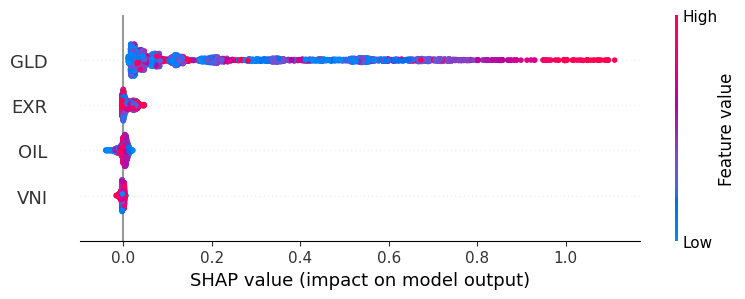

In [21]:
feature_names = ['GLD', 'VNI', 'OIL', 'EXR']

# Reshape shap_values để có dạng (216 * 10, 4)
shap_values_reshaped = shap_values.reshape(-1, shap_values.shape[2])  # (216 * 10, 4)
X_test_lstm_reshaped = X_test_lstm.reshape(-1, X_test_lstm.shape[2])  # (216 * 10, 4)

# Kiểm tra lại kích thước
print(shap_values_reshaped.shape)
print(X_test_lstm_reshaped.shape)

# Tạo summary plot
shap.summary_plot(shap_values_reshaped, X_test_lstm_reshaped, feature_names=feature_names)


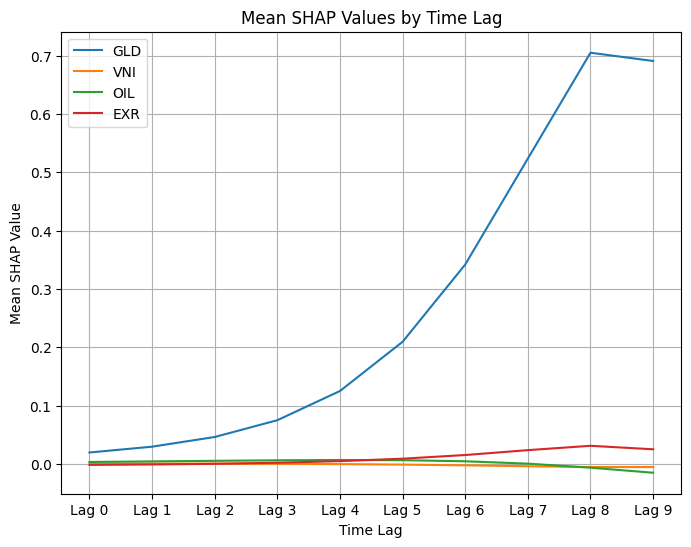

In [22]:

# Tên các đặc trưng
feature_names = ['GLD', 'VNI', 'OIL', 'EXR']

# Số timestep (trễ)
timesteps = X_test_lstm.shape[1]  # Ví dụ: 10

# Tính giá trị SHAP trung bình qua các mẫu tại từng timestep
mean_shap_values = np.mean(shap_values, axis=0)  # Shape: (timesteps, features)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
for i, feature in enumerate(feature_names):
    plt.plot(range(timesteps), mean_shap_values[:, i], label=feature)

# Tùy chỉnh biểu đồ
plt.title("Mean SHAP Values by Time Lag")
plt.xlabel("Time Lag")
plt.ylabel("Mean SHAP Value")
plt.xticks(range(timesteps), labels=[f"Lag {t}" for t in range(timesteps)])
plt.legend()
plt.grid(True)
plt.show()